Matrix structure:
```
++++   ++++
+X0+   +X1+
++++   ++++

X0 - books x word emb
X1 - books x cnn emb

E0 - books
E1 - word emb
E2 - cnn emb
```

In [1]:
# change the input cnn embeddings - to ResNet/GoogleNet/INceptionNet/VGG
# try reducing learning error for matrix factorization
# try diff regressors
# try multi label classification
# visualization of embeddings

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import pickle

In [3]:
dataset_folder = '../dataset/'
X0_file = dataset_folder + "sentenceBert_emb_tensor.pkl"
X1_file = dataset_folder + "googleNet_cnn_emb_tensor.pkl"

In [4]:
X0 = torch.load(X0_file)
print(X0.size())
X1 = torch.load(X1_file)
print(X1.size())

torch.Size([5000, 768])
torch.Size([5000, 1000])


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        self.enc_linear1 = nn.Linear(input_dim, 128)
        self.enc_linear2 = nn.Linear(128, embedding_dim)
        self.dec_linear1 = nn.Linear(embedding_dim, 128)
        self.dec_linear2 = nn.Linear(128, input_dim)
        self.emb = None
        
    def forward(self, x):
        x = self.enc_linear1(x)
        x = torch.relu(x)
        x = self.enc_linear2(x)
        self.emb = x # return embedding from encoder
        x = torch.relu(x)
        x = self.dec_linear1(x)
        x = torch.relu(x)
        x = self.dec_linear2(x)
        return x # use x for training
    

In [6]:
class matrix_factorization():
    def __init__(self, matrices, entity_list, matrix_entity_mapping, emb_dim):
        self.matrices = matrices
        self.entity_list = entity_list
        self.matrix_entity_mapping = matrix_entity_mapping # {"E0": ["X0", "X1"], "E1": ["X0"], "E2":["X1"]}
        self.emb_dim = emb_dim
        self.autoencoders = {} # {"E0": E0_autoencoder, "E1": E1_ae, ...}
        self.reconstructed_matrices = {} # {"X0": recon_X0, "X1": recon_X1, ...}
        self.embeddings = {} # {"E0": E0_emb, "E1": E1_emb, ...}
        self.concatenated_matrices = []
        self.optim = None
        self.criterion = nn.MSELoss()
        self.batch_size = 50
        self.convergence_threshold = 1e-4
        self.learning_rate = 0.001
        self.epoch_count = 250
        
    def init_autoencoders(self):
        # initialize autoencoder - one for each entity
        for entity, matrices in matrix_entity_mapping.items():
            if entity == "E0":
                C_E0 = torch.cat((matrices[0], matrices[1]), dim = 1)
                print(C_E0.size())
                E0_aec = Autoencoder(C_E0.size(1), self.emb_dim)
            elif entity == "E1":
                C_E1 = torch.transpose(matrices, 0, 1)
                print(C_E1.size())
                E1_aec = Autoencoder(C_E1.size(1), self.emb_dim)
            elif entity == "E2":
                C_E2 = torch.transpose(matrices, 0, 1)
                print(C_E2.size())
                E2_aec = Autoencoder(C_E2.size(1), self.emb_dim)
                
        self.concatenated_matrices = {"E0": C_E0, "E1": C_E1,"E2": C_E2}
        self.autoencoders = {"E0": E0_aec, "E1": E1_aec, "E2": E2_aec}
        self.optim = torch.optim.SGD(list(E0_aec.parameters()) + list(E1_aec.parameters()) + list(E2_aec.parameters()), lr = self.learning_rate)
    
    def train_autoencoder(self):
        # training
        prev_losses = []
        for epoch in range(0,self.epoch_count):
            shuffled_indices = {}
            avg_loss = {}
            ent_emb = {}
            for e in self.autoencoders.keys():
                shuffled_indices[e] = torch.randperm(self.concatenated_matrices[e].size(0))
                ent_emb[e] = torch.zeros(self.concatenated_matrices[e].size(0), self.emb_dim)
            
            for e in self.concatenated_matrices.keys():
                total_loss = 0
                num_batches = 0
                for count in range(0, self.concatenated_matrices[e].size(0), self.batch_size):
                    indices = shuffled_indices[e][count:count+self.batch_size] 
                    minibatch = self.concatenated_matrices[e][indices]
                    output = self.autoencoders[e](minibatch)
                    ent_emb[e][indices] = self.autoencoders[e].emb # assign emb of the mini batch to entity
#                     print(ent_emb[e][indices[0]])
                    loss = self.criterion(minibatch, output)
                    num_batches += 1
                    total_loss += loss
                avg_loss[e] = total_loss/num_batches
    
#             print(ent_emb['E0'][0])
            aec_loss = 0
    
            for v in avg_loss.values():
                aec_loss += v
#             print(f"Aec {aec_loss}")
            self.reconstructed_matrices['X0'] = torch.matmul(ent_emb['E0'], torch.transpose(ent_emb['E1'], 0, 1))
            self.reconstructed_matrices['X1'] = torch.matmul(ent_emb['E0'], torch.transpose(ent_emb['E2'], 0, 1))
            recon_loss = self.criterion(self.reconstructed_matrices['X0'], self.matrix_entity_mapping["E1"]) + \
                        self.criterion(self.reconstructed_matrices['X1'], self.matrix_entity_mapping["E2"])
#             print(f"recon loss {recon_loss}")
            aec_loss += recon_loss
#             print(f"Total {aec_loss}")
            self.optim.zero_grad()
            aec_loss.requires_grad_(True)
            aec_loss.backward()
            self.optim.step()

            if epoch % 10 == 0:
                print(f"Average loss for epoch {epoch} = {aec_loss}")
            if  (epoch > 100) and (len(prev_losses) > 0) and (prev_losses[-1] - aec_loss < self.convergence_threshold):
                print('Convergence!')
                break
            prev_losses.append(aec_loss)
        
    def get_embeddings(self):
        for e in self.matrix_entity_mapping.keys():
            out = self.autoencoders[e](self.concatenated_matrices[e])
            self.embeddings[e] = self.autoencoders[e].emb
        return self.embeddings
 

In [7]:
matrices = ["X0", "X1"]
entity_list = ["E0", "E1", "E2"]
matrix_entity_mapping = {"E0": (X0, X1), "E1": (X0), "E2":(X1)}
emb_dim = 50

model = matrix_factorization(matrices, entity_list, matrix_entity_mapping, emb_dim)
model.init_autoencoders()
model.train_autoencoder()
embeddings = model.get_embeddings()

torch.Size([5000, 1768])
torch.Size([768, 5000])
torch.Size([1000, 5000])
Average loss for epoch 0 = 4.9507036209106445
Average loss for epoch 10 = 4.2153639793396
Average loss for epoch 20 = 4.150623321533203
Average loss for epoch 30 = 4.105284214019775
Average loss for epoch 40 = 4.068666458129883
Average loss for epoch 50 = 4.03688907623291
Average loss for epoch 60 = 4.0085649490356445
Average loss for epoch 70 = 3.9832005500793457
Average loss for epoch 80 = 3.9606575965881348
Average loss for epoch 90 = 3.940873622894287
Average loss for epoch 100 = 3.9235332012176514
Average loss for epoch 110 = 3.9082412719726562
Average loss for epoch 120 = 3.894658088684082
Average loss for epoch 130 = 3.882481575012207
Average loss for epoch 140 = 3.8713903427124023
Average loss for epoch 150 = 3.8611793518066406
Average loss for epoch 160 = 3.851679801940918
Average loss for epoch 170 = 3.8428032398223877
Average loss for epoch 180 = 3.834439277648926
Average loss for epoch 190 = 3.8265163

In [8]:
# with open('embeddings.pkl', 'wb') as handle:
#     pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
torch.save(embeddings, "sentenceBert_googleNet_embeddings.pkl")

In [10]:
# Supervised learning

In [11]:
train_ids = torch.load("../dataset/train_book_id.pkl")
test_ids = torch.load("../dataset/test_book_id.pkl")
print(train_ids.size())
print(test_ids.size())

torch.Size([4000])
torch.Size([1000])


In [12]:
df = pd.read_csv("../dataset/books_with_genres.csv")
df.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic",category,binary_category
0,NaN,7,['189911'],US,eng,"[{'count': '58', 'name': 'to-read'}, {'count':...",B00071IKUY,False,4.03,NaN,...,31.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,"fantasy, paranormal",fiction
1,0842379428,566,[],US,eng,"[{'count': '6393', 'name': 'to-read'}, {'count...",NaN,False,4.26,B000FCKCJC,...,NaN,NaN,NaN,NaN,163.0,NaN,NaN,NaN,non-fiction,non-fiction
2,0590417010,193,[],US,eng,"[{'count': '450', 'name': 'to-read'}, {'count'...",NaN,False,4.43,B017RORXNI,...,NaN,NaN,NaN,NaN,2.0,109.0,1.0,NaN,children,non-fiction
3,1400041694,44,[],US,en-US,"[{'count': '362', 'name': 'to-read'}, {'count'...",NaN,False,3.75,B002OTKEP6,...,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,non-fiction,non-fiction
4,NaN,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",NaN,False,3.83,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,poetry,non-fiction


In [13]:
df[df.book_id.isin(train_ids.tolist())]

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic",category,binary_category
0,NaN,7,['189911'],US,eng,"[{'count': '58', 'name': 'to-read'}, {'count':...",B00071IKUY,False,4.03,NaN,...,31.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,"fantasy, paranormal",fiction
1,0842379428,566,[],US,eng,"[{'count': '6393', 'name': 'to-read'}, {'count...",NaN,False,4.26,B000FCKCJC,...,NaN,NaN,NaN,NaN,163.0,NaN,NaN,NaN,non-fiction,non-fiction
2,0590417010,193,[],US,eng,"[{'count': '450', 'name': 'to-read'}, {'count'...",NaN,False,4.43,B017RORXNI,...,NaN,NaN,NaN,NaN,2.0,109.0,1.0,NaN,children,non-fiction
3,1400041694,44,[],US,en-US,"[{'count': '362', 'name': 'to-read'}, {'count'...",NaN,False,3.75,B002OTKEP6,...,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,non-fiction,non-fiction
4,NaN,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",NaN,False,3.83,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,poetry,non-fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,NaN,10,['792787'],US,eng,"[{'count': '733', 'name': 'to-read'}, {'count'...",B014WARB1O,False,4.02,NaN,...,3.0,NaN,NaN,197.0,NaN,NaN,NaN,NaN,romance,fiction
3996,NaN,63,"['458556', '991375']",US,eng,"[{'count': '4294', 'name': 'to-read'}, {'count...",NaN,False,3.96,NaN,...,222.0,495.0,NaN,NaN,NaN,NaN,NaN,NaN,fiction,fiction
3997,NaN,256,['757811'],US,eng,"[{'count': '595', 'name': 'to-read'}, {'count'...",NaN,True,4.12,NaN,...,182.0,NaN,NaN,84.0,NaN,NaN,NaN,NaN,"fantasy, paranormal",fiction
3998,NaN,39,['816284'],US,eng,"[{'count': '899', 'name': 'to-read'}, {'count'...",NaN,True,3.96,NaN,...,25.0,NaN,NaN,11.0,NaN,NaN,13.0,NaN,"fantasy, paranormal",fiction


In [14]:
X_train = embeddings["E0"][0:4000].detach().numpy()
X_test = embeddings["E0"][4000:].detach().numpy()
print(X_train.shape)
print(X_test.shape)

(4000, 50)
(1000, 50)


In [15]:
y_train = df["average_rating"][0:4000]
y_test = df["average_rating"][4000:]
print(y_train.shape)
print(y_test.shape)

(4000,)
(1000,)


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
error = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

In [17]:
print(error)
print(r2)

0.17685695307014843
-0.014312720211472119


In [18]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
preds = svr.predict(X_test)
error = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

In [19]:
print(error)
print(r2)

0.18708901759431593
-0.0729958142076188


In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
df_pca = pd.DataFrame(pca.fit_transform(X_train), columns = ["comp1", "comp2"])
df_pca["y_train"] = y_train 
print(df_pca.shape)
df_pca.head()

(4000, 3)


,comp1,comp2,y_train
0,0.302259,0.172209,4.03
1,-0.941150,0.274957,4.26
2,-0.451539,-0.406467,4.43
3,-0.131162,-0.302699,3.75
4,0.042965,0.491294,3.83


In [21]:
df_pca["y_cat"] = df_pca["y_train"].apply(lambda x: int(x))

In [22]:
df_pca.head()

,comp1,comp2,y_train,y_cat
0,0.302259,0.172209,4.03,4
1,-0.941150,0.274957,4.26,4
2,-0.451539,-0.406467,4.43,4
3,-0.131162,-0.302699,3.75,3
4,0.042965,0.491294,3.83,3


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='comp1', ylabel='comp2'>

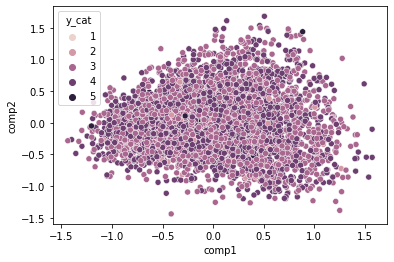

In [24]:
sns.scatterplot(x="comp1", y="comp2", data=df_pca, hue="y_cat")